# Drifting Models: A Step-by-Step Demo

**Paper:** Generative Modeling via Drifting

This demo walks you through the core algorithm with hands-on examples:

1. **Part 1: Core Algorithm** — The drifting loss and drift computation
2. **Part 2: Toy 2D** — Visualize dynamics on swiss roll & checkerboard

**More samples and full results can be found in the paper.**

---

# Install packages

In [1]:
!pip install -q matplotlib numpy torch torchvision tqdm einops

In [2]:
import os
import sys
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Device selection
# - In Colab: prefer CUDA (GPU) and warn if GPU isn't enabled
# - Locally: prefer CUDA, then Apple Silicon MPS, then CPU
IN_COLAB = (
    "google.colab" in sys.modules
    or os.environ.get("COLAB_GPU") is not None
    or os.environ.get("COLAB_TPU_ADDR") is not None
)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif (not IN_COLAB) and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

print(f"Using device: {DEVICE} (IN_COLAB={IN_COLAB})")
if IN_COLAB and DEVICE.type != "cuda":
    print(
        "[Warning] Colab is not running with GPU enabled. Please select 'Runtime -> Change runtime type -> GPU' in the menu and re-run this cell."
    )

Using device: cpu (IN_COLAB=True)
[Warning] Colab is not running with GPU enabled. Please select 'Runtime -> Change runtime type -> GPU' in the menu and re-run this cell.


# Part 1: Core Algorithm

**Traditional generative models** (Diffusion, Flow Matching) iterate at **inference time**.

**Drifting Models** move the iteration to **training time**:
- Each training step "drifts" the generated samples according to a drifting field
- At inference: just one forward pass (1 NFE)

## Training Objective

Given a generator $f_\theta$ that maps noise $\epsilon$ to samples, the training loss is:

$$
L = \mathbb{E}_{\epsilon} \Big[ \big\| f_\theta(\epsilon) - \text{stopgrad}\big(f_\theta(\epsilon) + \mathbf{V}_{p,q}(f_\theta(\epsilon))\big) \big\|^2 \Big]
$$

We move predictions toward their **drifted** versions. The drifting field $\mathbf{V}_{p,q}$, depending on the data distribution $p$ and the generated distribution $q$, tells each generated sample where to go. This can be implemented as the following code.

In [3]:

def drifting_loss(gen: torch.Tensor, pos: torch.Tensor, compute_drift):
    """Drifting loss: MSE(gen, stopgrad(gen + V))."""
    with torch.no_grad():
        V = compute_drift(gen, pos)
        target = (gen + V).detach()
    return F.mse_loss(gen, target)

## Mean-shift Drifting Field

Having described the general training objective, we now describe a concrete instantiation of the drifting field $\mathbf{V}_{p,q}$.

In principle, $\mathbf{V}_{p,q}$ can be a wide range of vector fields, as long as it satisfies $\mathbf{V}_{p,p} = \mathbf{0}$. In this paper, we use an instantiation inspired by **mean-shift**, defined as

$$
\mathbf{V}_{p,q}(\mathbf{x}) := \mathbf{V}_p^{+}(\mathbf{x}) - \mathbf{V}_q^{-}(\mathbf{x}),
$$

where

$$
\mathbf{V}_p^{+}(\mathbf{x}) := \frac{1}{Z_p(\mathbf{x})} \, \mathbb{E}_{\mathbf{y}^{+} \sim p} \big[ k(\mathbf{x}, \mathbf{y}^{+}) (\mathbf{y}^{+} - \mathbf{x}) \big], \quad \mathbf{V}_q^{-}(\mathbf{x}) := \frac{1}{Z_q(\mathbf{x})} \, \mathbb{E}_{\mathbf{y}^{-} \sim q} \big[ k(\mathbf{x}, \mathbf{y}^{-}) (\mathbf{y}^{-} - \mathbf{x}) \big].
$$

The normalizers are

$$
Z_p(\mathbf{x}) := \mathbb{E}_{\mathbf{y}^{+} \sim p} \big[ k(\mathbf{x}, \mathbf{y}^{+}) \big], \quad Z_q(\mathbf{x}) := \mathbb{E}_{\mathbf{y}^{-} \sim q} \big[ k(\mathbf{x}, \mathbf{y}^{-}) \big].
$$

Substituting into $\mathbf{V}_{p,q} = \mathbf{V}_p^{+} - \mathbf{V}_q^{-}$, we obtain the compact form

$$
\mathbf{V}_{p,q}(\mathbf{x}) = \frac{1}{Z_p(\mathbf{x}) Z_q(\mathbf{x})} \, \mathbb{E}_{\mathbf{y}^{+} \sim p, \, \mathbf{y}^{-} \sim q} \big[ k(\mathbf{x}, \mathbf{y}^{+}) \, k(\mathbf{x}, \mathbf{y}^{-}) \, (\mathbf{y}^{+} - \mathbf{y}^{-}) \big].
$$

---

### Implementation (batch-normalized Monte Carlo estimate)

In practice, we approximate the above expectation using mini-batches. Specifically, we use

$$
\mathbf{V}(\mathbf{x}) := \mathbb{E} \big[ K_B(\mathbf{x}, \mathbf{y}^{+}) \, K_B(\mathbf{x}, \mathbf{y}^{-}) \, (\mathbf{y}^{+} - \mathbf{y}^{-}) \big],
$$

where $K_B$ is a **batch-normalized kernel**: the kernel $k$ is normalized over samples in batch $B$.

This construction guarantees $\mathbf{V}_{p,p} = \mathbf{0}$: when $p = q$, the term $(\mathbf{y}^{+} - \mathbf{y}^{-})$ is anti-symmetric and cancels out in expectation. The resulting field can be efficiently estimated via Monte Carlo over mini-batches.

Below is a reference PyTorch-style implementation, where $k(\mathbf{x}, \mathbf{y}) = \exp(-\|\mathbf{x} - \mathbf{y}\| / \tau)$, and $K_B$ implements the normalization across both $\mathbf x$ and $\mathbf y$, since we found it to slightly improve performance.

In [4]:
# ============================================================
# Core: Compute Drift V and Loss (from toy_mean_drift.py)
# ============================================================

def compute_drift(gen: torch.Tensor, pos: torch.Tensor, temp: float = 0.05):
    """
    Compute drift field V with attention-based kernel.

    Args:
        gen: Generated samples [G, D]
        pos: Data samples [P, D]
        temp: Temperature for softmax kernel

    Returns:
        V: Drift vectors [G, D]
    """
    targets = torch.cat([gen, pos], dim=0)
    G = gen.shape[0]

    dist = torch.cdist(gen, targets)
    dist[:, :G].fill_diagonal_(1e6)  # mask self
    kernel = (-dist / temp).exp() # unnormalized kernel

    normalizer = kernel.sum(dim=-1, keepdim=True) * kernel.sum(dim=-2, keepdim=True) # normalize along both dimensions, which we found to slightly improve performance
    normalizer = normalizer.clamp_min(1e-12).sqrt()
    normalized_kernel = kernel / normalizer

    pos_coeff = normalized_kernel[:, G:] * normalized_kernel[:, :G].sum(dim=-1, keepdim=True)
    pos_V = pos_coeff @ targets[G:]
    neg_coeff = normalized_kernel[:, :G] * normalized_kernel[:, G:].sum(dim=-1, keepdim=True)
    neg_V = neg_coeff @ targets[:G]

    return pos_V - neg_V




## Visualize the Drifting Field

Let's see what the drifting field look like for a randomly initialized $q$.

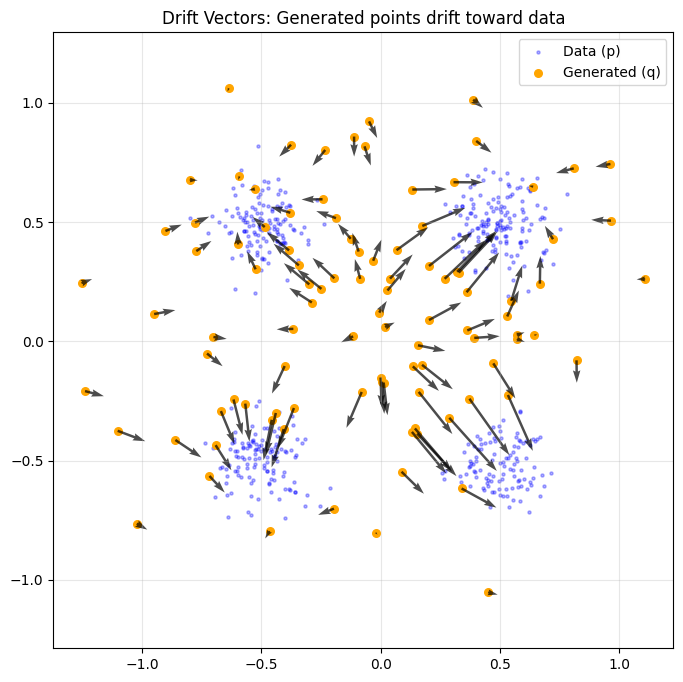

In [5]:
# Quick visualization of drift vectors
torch.manual_seed(42)

# Random generated points (from Gaussian)
gen_test = torch.randn(100, 2) * 0.5

# Target data: simple 4-mode Gaussian mixture
centers = torch.tensor([[-0.5, -0.5], [-0.5, 0.5], [0.5, -0.5], [0.5, 0.5]])
idx = torch.randint(0, 4, (500,))
pos_test = centers[idx] + torch.randn(500, 2) * 0.1

# Compute drift
drift_test = compute_drift(gen_test, pos_test, temp=0.2)

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(pos_test[:, 0], pos_test[:, 1], s=5, alpha=0.3, c='blue', label='Data (p)')
plt.scatter(gen_test[:, 0], gen_test[:, 1], s=30, c='orange', label='Generated (q)')
plt.quiver(gen_test[:, 0], gen_test[:, 1], drift_test[:, 0], drift_test[:, 1],
           scale=3, color='black', alpha=0.7, width=0.004)
plt.legend()
plt.title('Drift Vectors: Generated points drift toward data')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

---

# Part 2: Toy 2D Examples

Let's train on 2D distributions to visualize the full training dynamics.

We'll use two classic test distributions:
- **Checkerboard**: 4 diagonally-arranged squares (tests mode coverage)
- **Swiss Roll**: Spiral pattern (tests learning complex geometry)

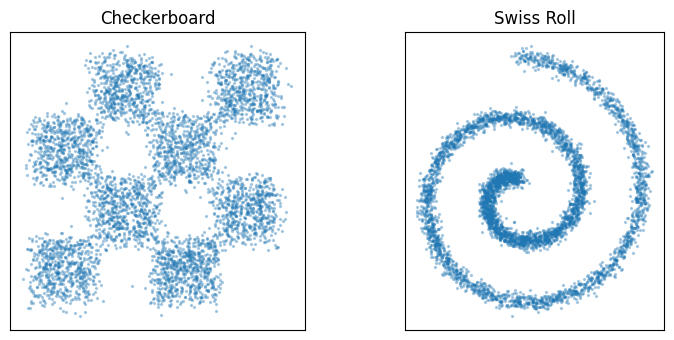

In [6]:
# ============================================================
# Toy Dataset Samplers (minimal; copied from toy_mean_drift.py)
# ============================================================

def sample_checkerboard(n: int, noise: float = 0.05, seed: int | None = None) -> torch.Tensor:
    g = torch.Generator().manual_seed(seed) if seed is not None else None
    b = torch.randint(0, 2, (n,), generator=g)
    i = torch.randint(0, 2, (n,), generator=g) * 2 + b
    j = torch.randint(0, 2, (n,), generator=g) * 2 + b
    u = torch.rand(n, generator=g)
    v = torch.rand(n, generator=g)
    pts = torch.stack([i + u, j + v], dim=1) - 2.0
    pts = pts / 2.0
    if noise > 0:
        pts = pts + noise * torch.randn(pts.shape, generator=g)
    return pts


def sample_swiss_roll(n: int, noise: float = 0.03, seed: int | None = None) -> torch.Tensor:
    g = torch.Generator().manual_seed(seed) if seed is not None else None
    u = torch.rand(n, generator=g)
    t = 0.5 * math.pi + 4.0 * math.pi * u
    pts = torch.stack([t * torch.cos(t), t * torch.sin(t)], dim=1)
    pts = pts / (pts.abs().max() + 1e-8)
    if noise > 0:
        pts = pts + noise * torch.randn(pts.shape, generator=g)
    return pts


# quick look
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))
for ax, (name, sampler) in zip(axes, [("Checkerboard", sample_checkerboard), ("Swiss Roll", sample_swiss_roll)]):
    pts = sampler(5000).numpy()
    ax.scatter(pts[:, 0], pts[:, 1], s=2, alpha=0.3)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [7]:
# ============================================================
# Training Loop for Toy 2D
# ============================================================
from functools import partial
class MLP(nn.Module):
    """MLP: noise -> output. 3 hidden layers with SiLU."""
    def __init__(self, in_dim=32, hidden=256, out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, out_dim),
        )
    def forward(self, z):
        return self.net(z)

def train_toy(sampler, steps=2000, data_batch_size=2048, gen_batch_size=2048, lr=1e-3, temp=0.05,
              in_dim=32, hidden=256, plot_every=500, seed=42):
    """Train drifting model. Returns model and loss history."""
    torch.manual_seed(seed)
    model = MLP(in_dim=in_dim, hidden=hidden, out_dim=2).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    loss_history = []
    ema = None
    pbar = tqdm(range(1, steps + 1))
    for step in pbar:
        pos = sampler(data_batch_size).to(DEVICE)
        gen = model(torch.randn(gen_batch_size, in_dim, device=DEVICE))
        loss = drifting_loss(gen, pos, compute_drift=partial(compute_drift, temp=temp))

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_history.append(loss.item())
        ema = loss.item() if ema is None else 0.96 * ema + 0.04 * loss.item()
        pbar.set_postfix(loss=f"{ema:.2e}")

        if step % plot_every == 0 or step == 1:
            with torch.no_grad():
                vis = model(torch.randn(5000, in_dim, device=DEVICE)).cpu().numpy()
                gt = sampler(5000).numpy()
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))
            ax1.scatter(gt[:, 0], gt[:, 1], s=2, alpha=0.3, c='black')
            ax1.set_title('Target'); ax1.set_aspect('equal'); ax1.axis('off')
            ax2.scatter(vis[:, 0], vis[:, 1], s=2, alpha=0.3, c='tab:orange')
            ax2.set_title(f'Generated (step {step})'); ax2.set_aspect('equal'); ax2.axis('off')
            plt.tight_layout(); plt.show()

    return model, loss_history

Training on Swiss Roll...


  0%|          | 0/2000 [00:00<?, ?it/s]

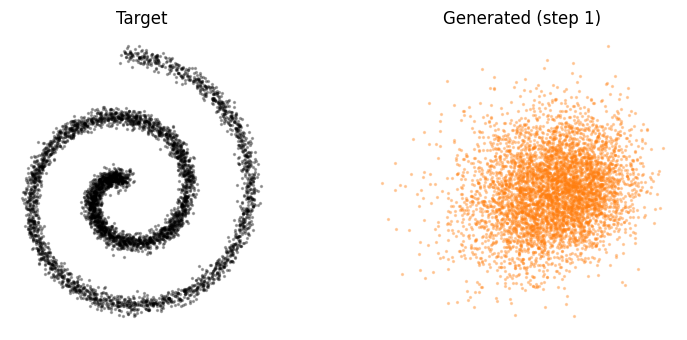

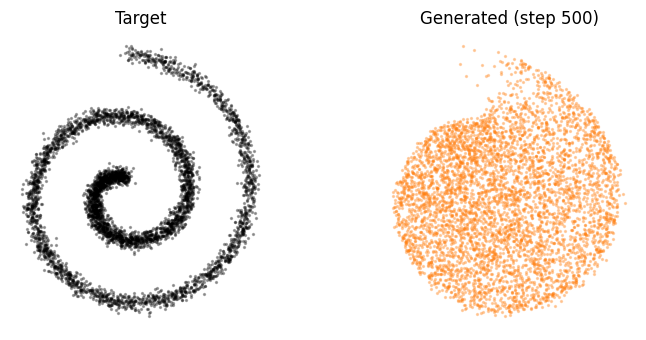

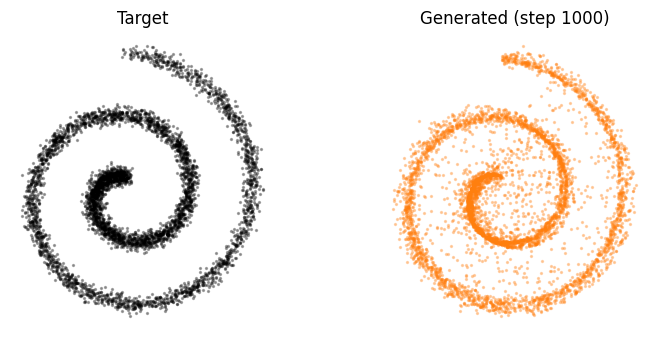

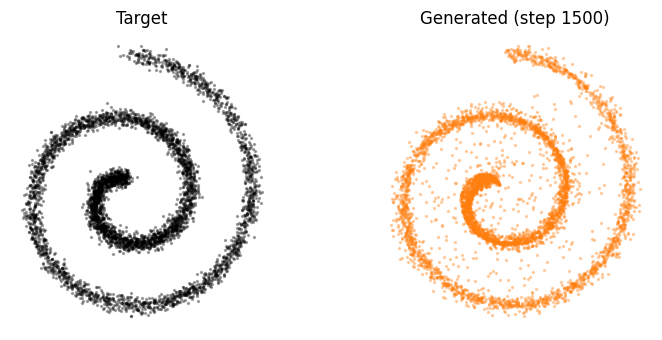

In [ ]:
# Train on Swiss Roll
print("Training on Swiss Roll...")
model_swiss, loss_swiss = train_toy(sample_swiss_roll, steps=2000, lr=1e-3, temp=0.05)

plt.figure(figsize=(6, 3))
plt.plot(loss_swiss, alpha=0.7)
plt.xlabel('Step'); plt.ylabel('Loss'); plt.title('Swiss Roll Loss Curve')
plt.yscale('log'); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()



Training on Checkerboard...


  0%|          | 0/2000 [00:00<?, ?it/s, loss=2.48e-07]

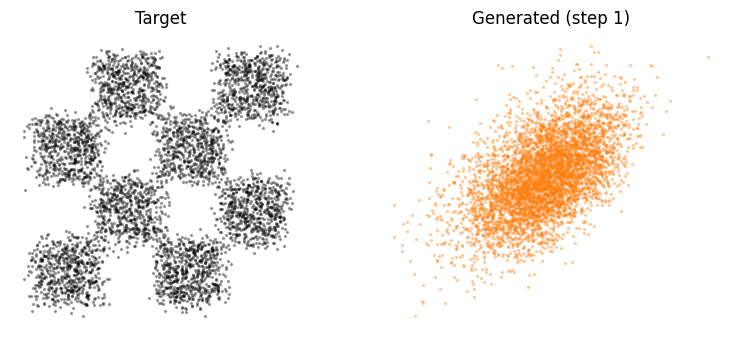

 24%|██▍       | 488/2000 [00:04<00:10, 146.83it/s, loss=1.20e-04]

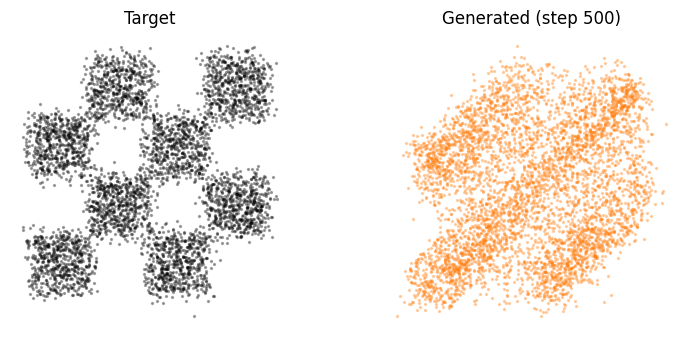

 50%|████▉     | 993/2000 [00:09<00:09, 110.73it/s, loss=4.71e-05]

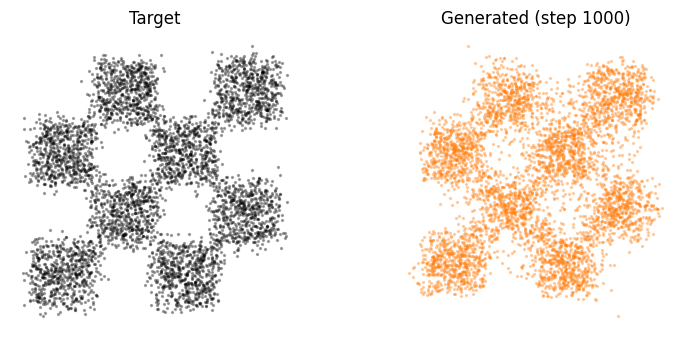

 75%|███████▍  | 1498/2000 [00:14<00:08, 61.57it/s, loss=3.77e-05] 

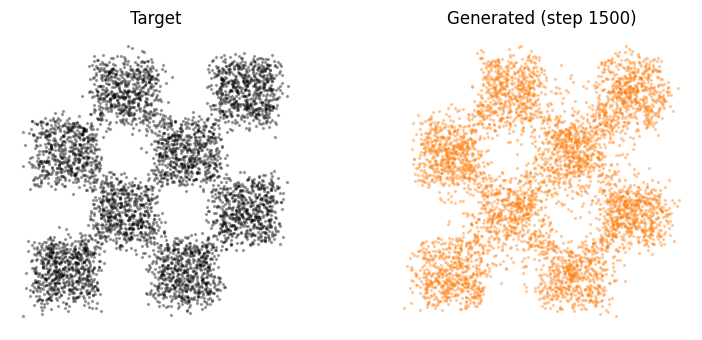

100%|█████████▉| 1994/2000 [00:19<00:00, 102.69it/s, loss=3.56e-05]

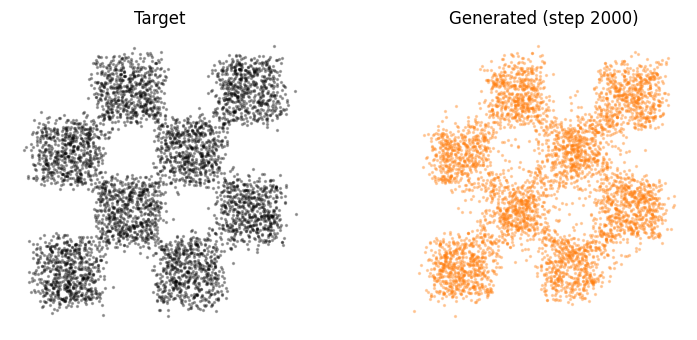

100%|██████████| 2000/2000 [00:19<00:00, 102.53it/s, loss=3.56e-05]


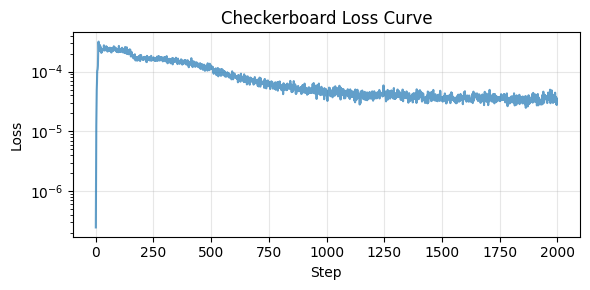

In [ ]:

# Train on Checkerboard
print("\nTraining on Checkerboard...")
model_checker, loss_checker = train_toy(sample_checkerboard, steps=2000, lr=1e-3, temp=0.05)

plt.figure(figsize=(6, 3))
plt.plot(loss_checker, alpha=0.7)
plt.xlabel('Step'); plt.ylabel('Loss'); plt.title('Checkerboard Loss Curve')
plt.yscale('log'); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()